####**series RLC circuit with driving function $f(t) = Vsin(ωt)$**
John Morrow

Note: in the following code:
- time, $t$, is represented by ${t\_coloc}$
- ${objective}$ is represented by ${model\_loss}$

as compared to the terminology in the article, $\textit{Physics-Informed Neural Network with Forcing Function}$.

https://github.com/jmorrow1000/PINN-with-forcing-function/blob/main/PINN_with_forcing_function.pdf

epoch = 0  loss = 1359.16   lr = 0.01000
epoch = 1000  loss = 299.933   lr = 0.01000
epoch = 2000  loss = 253.738   lr = 0.00750
epoch = 3000  loss = 219.18   lr = 0.00750
epoch = 4000  loss = 221.851   lr = 0.00562
epoch = 5000  loss = 190.437   lr = 0.00562
epoch = 6000  loss = 214.132   lr = 0.00422
epoch = 7000  loss = 176.682   lr = 0.00422
epoch = 8000  loss = 168.891   lr = 0.00316
epoch = 9000  loss = 106.755   lr = 0.00316
epoch = 10000  loss = 66.9751   lr = 0.00237
epoch = 11000  loss = 41.1992   lr = 0.00237
epoch = 12000  loss = 27.8859   lr = 0.00178
epoch = 13000  loss = 18.4136   lr = 0.00178
epoch = 14000  loss = 13.6565   lr = 0.00133
epoch = 15000  loss = 7.9008   lr = 0.00133
epoch = 16000  loss = 6.73001   lr = 0.00100
epoch = 17000  loss = 3.45818   lr = 0.00100
epoch = 18000  loss = 2.59036   lr = 0.00075
epoch = 19000  loss = 1.50333   lr = 0.00075
epoch = 20000  loss = 1.14485   lr = 0.00056
epoch = 21000  loss = 0.740711   lr = 0.00056
epoch = 22000  loss = 0.

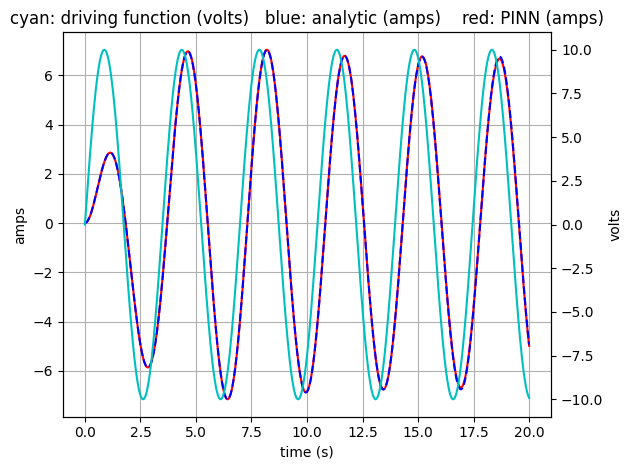

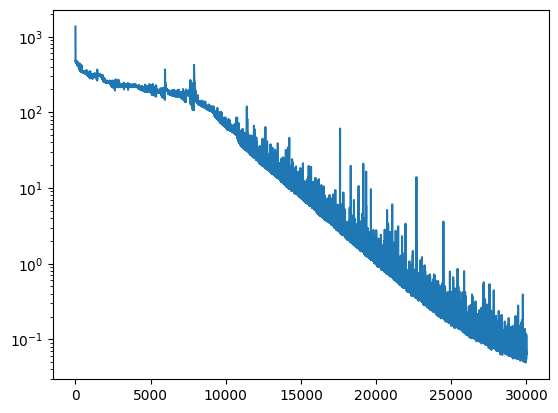

In [ ]:

import datetime
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math

torch.manual_seed(42)
###########

# Hyperparameters
batch_size: int = 32
neurons = 128  # no. per layer
epochs: int = 30001
learning_rate = 0.01
t_start = 0  # simulation start time, secs
t_end = 20  # simulation end time, secs
ni: int = 11  # number coloc pts per sec

# Circuit Parameters

# Under-damped parameters yielding w0=1.486 and mu=1.432
R = 1.2  # over (>4.4877), critical (4.4877), under (<4.4877) resistance, ohm
L = 1.51  # inductance, H
C = 0.3  # capacitance, F

# Driving Force
Vpk = 10.0  # peak voltage, volts
w = 1.8 # 1.8  # radial frequency, radians/sec

# forcing function
def F(t):
  return Vpk * torch.sin(w * t)
# derivative of the forcing function
def dF(t):
  return w * Vpk * torch.cos(w * t)

# co-location points
t_range = [t_start, t_end]
ncoloc = int(ni * (t_range[1] - t_range[0]))  # number of co-location pts
t_coloc = torch.FloatTensor(np.linspace(t_range[0], t_range[1],
                                        ncoloc, endpoint=True).reshape(-1, 1))
dataset = torch.utils.data.TensorDataset(t_coloc)

# Create DataLoader
# dataset = Build_Data(t_coloc)
coloc_load = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# initial conditions:
   #  f(t) initial conditions
t_init = torch.FloatTensor(np.array([0.0]).reshape(-1, 1))  # time, sec
i_init = torch.FloatTensor(np.array([0.0]).reshape(-1, 1))  # current, A

   #  f'(t) initial conditions
t_init2 = torch.FloatTensor(np.array([0.0]).reshape(-1, 1))  # time, sec
v_init2 = torch.FloatTensor(np.array([F(t_init2)]).reshape(-1,1))  # L * d/dt(i) = F(0)
t_init2.requires_grad = True  # variable in a gradient

# Build neural network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model_layers = nn.Sequential(
            nn.Linear(1, neurons),
            nn.GELU(),
            nn.Linear(neurons,neurons),
            nn.GELU(),
            nn.Linear(neurons,1),
        )
    def forward(self, x):
      for layer in self.model_layers:
            x = layer(x)
      return x

def squared_difference(input, target):
    return (input - target) ** 2

# instantiate model
model = NeuralNetwork()
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.75)

# closure function - PyTorch
#    computes loss, clears gradients, back pass to compute gradients
def closure(): # clears gradients, computes and returns loss

  # model_loss1: initial condition i_init @ t_init -> f(t) initial condition
        pred_init = model(t_init)
        model_loss1 = torch.mean(squared_difference(pred_init, i_init))

  # model_loss2: residual
        pred_y = model(t_points)
        dfdx = torch.autograd.grad(pred_y.sum(), t_points, create_graph=True)[0]
        dfdx2 = torch.autograd.grad(dfdx.sum(), t_points, create_graph=True)[0]
        residual = dfdx2 + dfdx * (R / L) + pred_y / (L * C) - dF(t_points) * (1 / L)
        model_loss2 = torch.mean(squared_difference(residual, torch.zeros_like(t_points)))
        # if epoch % 1000 == 0:
        # if epoch == epochs-1:
        #   print(f'epoch:  {epoch}   residual:  {residual}')

  # model_loss3: initial condition i_init2 @ t_init2 -> f'(t) initial condition
        pred_init2 = model(t_init2)
        dfdx = torch.autograd.grad(pred_init2.sum(), t_init2, create_graph=True)[0]  # f'(t)
        vl = dfdx * L  # inductor voltage due to dfdx
        model_loss3 = torch.mean(squared_difference(vl, v_init2))

  # total loss
        model_loss = model_loss1 + model_loss2 + model_loss3

        optimizer.zero_grad()
        # sets any previous gradient values to zero before running backward(),
        # or else the new gradient will be added to the old one

        model_loss.backward(retain_graph=True)  # calculates gradients from loss
        return model_loss

# Training loop - PyTorch
loss_epoc_log = np.zeros(epochs)
for epoch in range(epochs):
  loss_batch_list = []
  for points in coloc_load:
    t_points = np.array(points)
    t_points = t_points.squeeze()
    t_points = torch.FloatTensor(t_points).reshape(-1, 1)
    t_points.requires_grad = True
    optimizer.step(closure)  #  updates model weights
    loss_batch_list.append(closure().item())
  loss = np.sum(np.array(loss_batch_list))
  # loss = closure().item()  # converts tensor value to numpy
  loss_epoc_log[epoch] = loss
  scheduler.step()
  if epoch % 1000 == 0:
    last_lr = float(scheduler.get_last_lr()[0])
    print(f'epoch = {epoch}  loss = {loss:G}   lr = {last_lr:.5f}')

# compare PINN results vs analytical results
num_test_pts = 1000
t_test = torch.FloatTensor(np.linspace(t_range[0], t_range[1], num_test_pts,
                                       endpoint=True)).reshape(-1, 1)
i_calc = np.zeros(num_test_pts)

i_train = model(t_coloc)  # for plotting co-location pts
i_test = model(t_test)  # iPINN results

F_test = np.zeros(num_test_pts)

# driving function test points
F_test = F(t_test)

# Analytical results
w0 = 1/math.sqrt(L * C)
lmbda = R/L
mu = math.sqrt(abs((lmbda/2)**2 - w0**2)) + 1e-10
Den = (w**2 - w0**2)**2 + lmbda**2 * w**2
P = lmbda/(4*mu) * (w**2 + w0**2)
Q = 1/2 * (w**2 - w0**2)
print(f'R: {R}   L: {L}   C: {C}')
print(f'lambda: {lmbda:.3f}    mu: {mu:.3f}    w0: {w0:.3f}    w: {w:.3f}')

# i_tran: transient response,  i_ss:  steady state response
i_tran = np.zeros(num_test_pts)
i_ss = np.zeros(num_test_pts)

# critically-damped transient (lamda/2 = w0)
if mu < 0.01:
  print('critically-damped transient')
  i_tran = Vpk*w/(L*Den) * ((w**2 - w0**2)*torch.exp(-(lmbda/2)*t_test) -
                           (w**2 + w0**2)*(lmbda/2)*t_test*torch.exp(-(lmbda/2)*t_test))
# under-damped transient
elif lmbda/2 < w0:
  print('under-damped transient')
  i_tran = Vpk*w/(L*Den) * torch.exp(-(lmbda/2)*t_test) * (-(2*P) * torch.sin(mu*t_test) +
                                                     2*Q*(torch.cos(mu*t_test)))
# over-damped transient
elif lmbda/2 > w0:
  print('over-damped transient')
  i_tran = Vpk*w/(L*Den) * torch.exp(-(lmbda/2)*t_test) * ((P+Q)*torch.exp(-mu*t_test) +
                                                          (Q-P)*torch.exp(mu*t_test))

# steady-state
i_ss = Vpk*w/(L*Den) * ((w0**2 - w**2)*torch.cos(w*t_test) + lmbda*w*torch.sin(w*t_test))

i_calc = i_ss + i_tran

fig, ax1 = plt.subplots()
plt.title('cyan: driving function (volts)   blue: analytic (amps)    red: PINN (amps)')

ax1.set_xlabel('time (s)')
ax1.set_ylabel('amps')
with torch.no_grad():
  ax1.plot(t_test.numpy(), i_test.numpy(), 'r', t_test.numpy(), i_calc, 'b--')
ax1.tick_params(axis='y')
plt.grid(visible=True)

ax2 = ax1.twinx()

ax2.set_ylabel('volts')
ax2.plot(t_test.numpy(), F_test, 'c')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

# Plot loss
plt.plot(loss_epoc_log)
plt.yscale("log")
plt.show()
